# TP2

#Imports

In [ ]:
#library(ggplot2)
#library(rpart)
#library(class)
if (!require(randomForest)) {
  install.packages("randomForest", dependencies = T)
}
library(randomForest)
if (!require(kernlab)) {
  install.packages("kernlab", dependencies = T)
}
library(kernlab)
library(MASS)

Loading required package: randomForest

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘randomForest’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.

Loading required package: kernlab

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘kernlab’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Ejercicio 1

## Wrapper Greedy Forward

In [ ]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para forward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante
#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{
	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		    features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>0){
		cat("\nFinal ranking ")
		cat("\nFeatures: ",list.feat)
	}

 	return(list.feat)
}

## Wrapper Greedy Backward

In [ ]:
#-------------------------------------------------------------------------------------
#Funcion general para backward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante
#-------------------------------------------------------------------------------------
backward.ranking <- function(x, y, method, verbosity=0, ...) {
	max.feat <- dim(x)[2]      # total de features
	num.feat <- max.feat       # número actual de features
	list.feat <- 1:max.feat    # lista para guardar los features elegidos, inicializo con todos
	final.feat <- c()

	# Inicialmente, entreno el modelo con todas las variables y mido el error
	x.train <- x
	class.error <- double(max.feat)  # inicializo el vector para guardar el error de cada modelo
	full.error <- do.call(method, c(list(x.train, y), list(...)))

	if (verbosity > 1) cat("\nInitial error with all features: ", full.error, "\n")

	# Loop principal. En cada paso, elimino una variable, entreno el modelo y mido el error.
	while (num.feat > 1) {
		class.error <- double(num.feat)

		# Para cada variable que queda, la elimino, entreno el modelo y mido el error.
		for (i in 1:num.feat) {
			features <- list.feat[-i]  # quito una variable
			x.train <- x[, features,drop=F]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)))
		}

		if (verbosity > 2) cat("\nFeatures:\n", list.feat, "\nErrors:\n", class.error)

		# Me quedo con la eliminación que minimiza el aumento del error.
		worst.index <- which.min(class.error)
		if (verbosity > 1) cat("\n---------\nStep ", max.feat - num.feat + 1, "\nFeature removed: ", list.feat[worst.index], "\n")

		final.feat <- c(final.feat, list.feat[worst.index])
		list.feat <- list.feat[-worst.index]  # elimino el feature de la lista
		num.feat <- num.feat - 1  # actualizo el número de features

		if (verbosity > 2) cat("\nNew feature list: ", list.feat)
	}

	final.feat <- rev(c(final.feat, list.feat[1]))

	if (verbosity > 0) {
		cat("\nFinal ranking ")
		cat("\nFeatures: ", final.feat)
	}

	return(final.feat)
}

## Filter con test no paramétrico Kruskal-Wallis

In [ ]:
# Función para la selección de características usando el test Kruskal-Wallis
# input:
# x: matriz de features
# y: vector de respuesta (debe ser categórico para Kruskal-Wallis)
# verbosity: nivel de detalle en los mensajes impresos
# output:
# ranked.features: índices de las características ordenadas por importancia
kruskal.ranking <- function(x, y, verbosity = 0) {
  max.feat <- dim(x)[2]  # total de features
  statistics <- double(max.feat)  # vector para almacenar los p-valores de cada característica

  # Para cada característica, aplico el test Kruskal-Wallis y guardo el p-valor
  for (i in 1:max.feat) {
    feature <- x[, i]
    statistics[i] <- kruskal.test(feature ~ y)$statistic
    if (verbosity > 1) cat("\nFeature ", i, " statistic: ", statistics[i])
  }

  # Ordeno las características según el p-valor (menor p-valor es mayor importancia)
  ranked.features <- order(statistics, decreasing=T)

  if (verbosity > 0) {
		cat("\nFinal ranking ")
    cat("\nFeatures: ", ranked.features)
    if (verbosity > 1) cat("\nStatictics: ", statistics[ranked.features], "\n")
  }

  return(ranked.features)
}

## RFE

In [ ]:
# Función para selección de características usando Recursive Feature Elimination (RFE)
# input:
# x: matriz de features
# y: vector de respuesta
# method: función para entrenar un modelo que calcule la importancia de las características
# ...: parámetros adicionales para el método 'method'
# verbosity: nivel de detalle en los mensajes impresos
# output:
# R: índices de las características seleccionadas, ordenadas de más a menos importante
rfe.ranking <- function(x, y, method, verbosity = 0, ...) {
  p <- dim(x)[2]  # total de features
  list.feat <- 1:p
  R <- c()
  for(i in 1:p) {
	model <- do.call(method, c(list(x[, list.feat, drop = FALSE], y), list(...)))
	least.important <- model$feats[1]

	if (verbosity > 1) {
      cat("\nIteration with", length(list.feat), "features.")
	  cat("\nFeatures: ", list.feat)
	  cat("\nFeatures indexes: ", model$feats)
      cat("\nFeature importances: ", model$imp)
      cat("\nRemoving feature: ", list.feat[least.important], "\n")
    }

	R[p-i+1] <- list.feat[least.important]
	list.feat <- list.feat[-least.important]
  }

  if (verbosity > 0) {
		cat("\nFinal ranking ")
    cat("\nFeatures: ", R)
  }

  return(R)
}

## Funciones estimacion greedy

In [ ]:
#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
  invisible(capture.output(model <- ksvm(as.matrix(x.train), as.factor(y), type=type,kernel=kernel,C=C,cross = cross)))
	return ( model@cross )
}

## Funciones estimacion RFE

In [ ]:
#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	invisible(capture.output(m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)))

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}

## Pruebas punto 1

In [ ]:
#demo: aplicar el wrapper a los datos de iris
data(iris)
FORW.rf <-forward.ranking(iris[,-5],iris[,5],method="rf.est",tot.trees=100,equalize.classes=F)
FORW.lda<-forward.ranking(iris[,-5],iris[,5],method="lda.est")

BACK.rf <-backward.ranking(iris[,-5],iris[,5],method="rf.est", tot.trees=100,equalize.classes=F)
BACK.lda<-backward.ranking(iris[,-5],iris[,5],method="lda.est")

ranking.kruskal <- kruskal.ranking(iris[,-5], iris[,5])

RFE.rf <- rfe.ranking(iris[,-5], iris[,5],method="imp.rf", verbosity=3)


Iteration with 4 features.
Features:  1 2 3 4
Features indexes:  2 1 4 3
Feature importances:  4.245404 10.61962 32.12191 33.43966
Removing feature:  2 

Iteration with 3 features.
Features:  1 3 4
Features indexes:  1 3 2
Feature importances:  15.35948 32.60541 35.28991
Removing feature:  1 

Iteration with 2 features.
Features:  3 4
Features indexes:  1 2
Feature importances:  33.53396 35.25417
Removing feature:  3 

Iteration with 1 features.
Features:  4
Features indexes:  1
Feature importances:  195.7811
Removing feature:  4 

Final ranking 
Features:  4 3 1 2

# Ejercicio 2

## Función de generación

In [ ]:
#hacer una funcion que cree datos, 2 clases (-1 y 1,n puntos de cada una), d dimensiones, de ruido uniforme [-1,1], con la clase al azar
crea.ruido.unif <- function(n=100, d=2) {
  x<-runif(2*n*d,min=-1)	#genero los datos
  dim(x)<-c(2*n,d)
  return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

## DatosA

### Generación de los datos

In [ ]:
#---------------------------------------------------------------------------
#CREA DATASET datosA
#Dataset artificial con orden de importancia: 8-6-4-2
#---------------------------------------------------------------------------
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos
datosADF <- as.data.frame(datosA)
colnames(datosADF) <- c(paste0("F_", 1:d), "Class")

### Gráficas

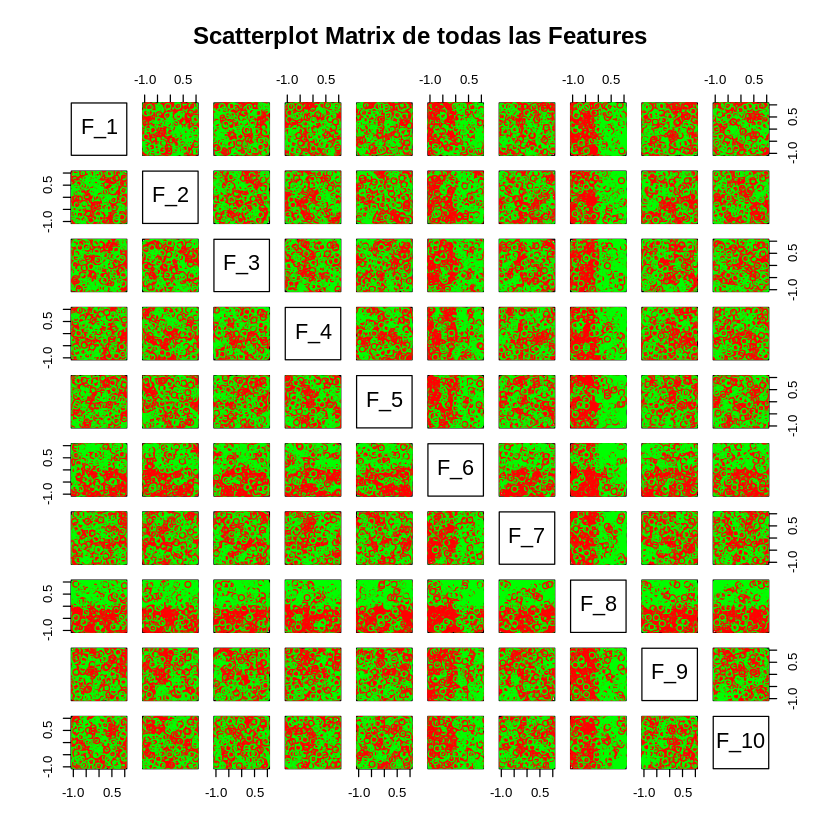

In [ ]:
class_colors <- c("red", "green")
# Creamos un scatterplot matrix con todas las features
pairs(datosADF[, 1:d], col = class_colors[as.numeric(datosADF$Class)], pch = 1, main = "Scatterplot Matrix de todas las Features")

En este gráfico se puede apreciar como las variables 8 y 6 parecen agrupar los datos mas que las otras y que claramente influyen en la predicción. Si bien esto tambien es cierto para las variables 4 y 2, no se puede distinguir un agrupamiento.

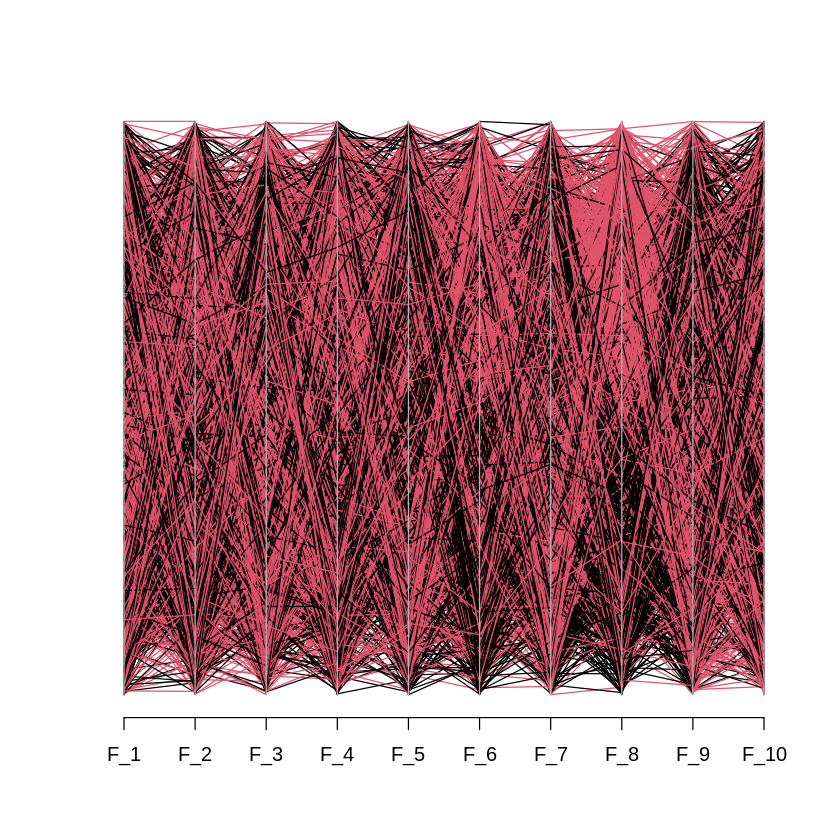

In [ ]:
parcoord(datosADF[, 1:d],col=datosADF[, d+1])

Nuevamente en este gráfico podemos ver que la variable 8 parece separar casos ya que claramente hay mas lineas rojas del lado de arriba que del lado de abajo para esta feature. Lo mismo se aprecia en menor medida para 6.

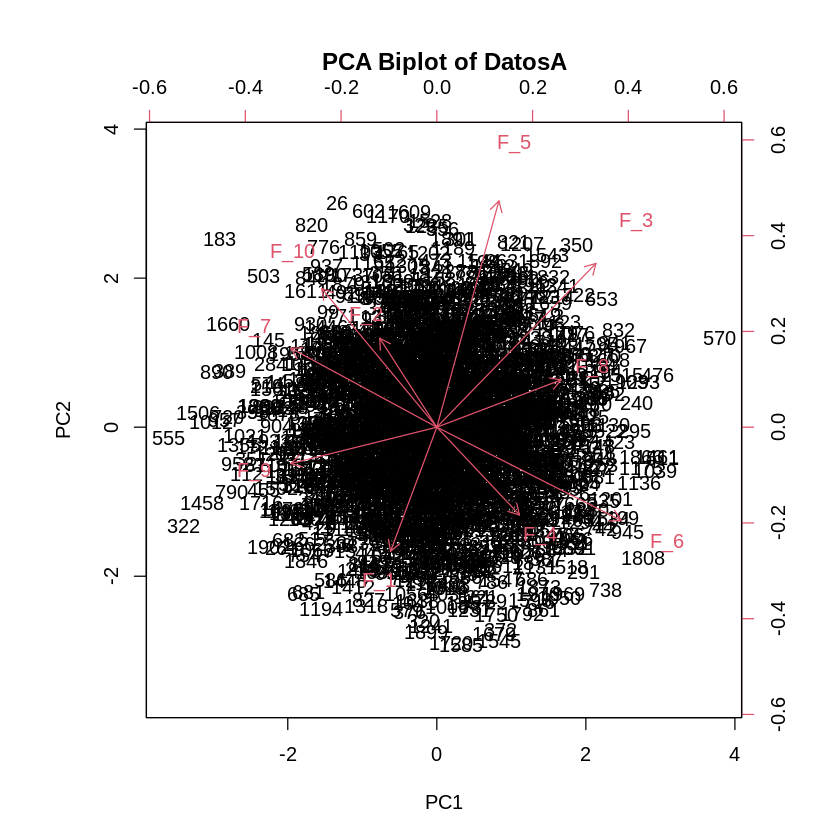

In [ ]:
pca_datosA <- prcomp(datosADF[, 1:d], center = TRUE, scale. = TRUE)
biplot(pca_datosA, scale = 0,
       main = "PCA Biplot of DatosA")

Se puede apreciar en el biplot que hay agrupaciones de variables, como puede ser F_2 y F_10 pero esto realmente no tienen ningún significado ya que si volvemos a correr el experimento, el resultado va a ser completamente distinto, lo cual tiene completo sentido ya que todas estas variables son independientes. Ninguna de las variables tiene una distribución que separe los datos ya que todas son ruído uniforme.

### Selección de variables

In [ ]:
cat("\nWrapper Greedy Forward Random Forest")
DA.FORW.rf <- forward.ranking(datosA[,1:d],datosA[,d+1],method="rf.est", verbosity=1)
cat("\n\nWrapper Greedy Forward LDA")
DA.FORW.lda <- forward.ranking(datosA[,1:d],datosA[,d+1],method="lda.est", verbosity=1)
cat("\n\nWrapper Greedy Forward SVM")
DA.FORW.svm <- forward.ranking(datosA[,1:d],datosA[,d+1],method="svm.est", verbosity=1)

cat("\n\n")
cat("\n\nWrapper Greedy Backward Random Forest")
DA.BACK.rf <- backward.ranking(datosA[,1:d],datosA[,d+1],method="rf.est", verbosity=1)
cat("\n\nWrapper Greedy Backward LDA")
DA.BACK.lda <- backward.ranking(datosA[,1:d],datosA[,d+1],method="lda.est", verbosity=1)
cat("\n\nWrapper Greedy Backward SVM")
DA.BACK.svm <- backward.ranking(datosA[,1:d],datosA[,d+1],method="svm.est", verbosity=1)

cat("\n\n")
cat("\nKruskal-Wallis")
DA.KRUS <- kruskal.ranking(datosA[,1:d],datosA[,d+1], verbosity=1)

cat("\n\n")
cat("\nRFE Random Forest")
DA.RFE.rf <- rfe.ranking(datosA[,1:d],datosA[,d+1],method="imp.rf", verbosity=1)
cat("\n\nRFE SVM")
DA.RFE.svm <- rfe.ranking(datosA[,1:d],datosA[,d+1],method="imp.linsvm", verbosity=1)


Wrapper Greedy Forward Random Forest
Final ranking 
Features:  8 4 6 2 10 7 9 1 5 3

Wrapper Greedy Forward LDA
Final ranking 
Features:  8 10 3 9 7 1 5 2 4 6

Wrapper Greedy Forward SVM
Final ranking 
Features:  8 3 5 1 9 7 2 10 4 6



Wrapper Greedy Backward Random Forest
Final ranking 
Features:  8 4 5 10 2 3 7 1 9 6

Wrapper Greedy Backward LDA
Final ranking 
Features:  8 1 7 3 10 9 5 2 4 6

Wrapper Greedy Backward SVM
Final ranking 
Features:  8 3 7 5 9 1 2 10 4 6


Kruskal-Wallis
Final ranking 
Features:  8 6 4 2 5 1 10 7 3 9


RFE Random Forest
Final ranking 
Features:  8 6 4 2 10 5 9 3 1 7

RFE SVM
Final ranking 
Features:  8 6 4 2 5 7 1 9 3 10

### Análisis

Todos los métodos lograron determinar que la feature mas importante era la octava, luego con respecto a la sexta feature, que es la segunda mas importante, todos los métodos Wrapper la dejaron al final menos Forward Random Forest, donde sorprendentemente logró obtener las 4 variables importantes en los primeros 4 lugares.

El test de Kruskal-Wallis y RFE lograron determinar las 4 variables mas importantes y en el orden correcto. Cabe destacar que esto funcionó en Kruskall-Wallis ya que en este problema las variables son independientes entre si. Teniendo esto último en cuenta, mi precepción es que RFE es el método mas robusto, sin importar el clasificador utilizado.

## DatosB

### Generación de los datos

In [ ]:
#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con dos variables relevantes (1-2) y dos variables que son importantes pero que no resuelven el problema (3-4)
#---------------------------------------------------------------------------
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos
datosBDF <- as.data.frame(datosB)
colnames(datosBDF) <- c(paste0("F_", 1:d), "Class")

### Gráficas

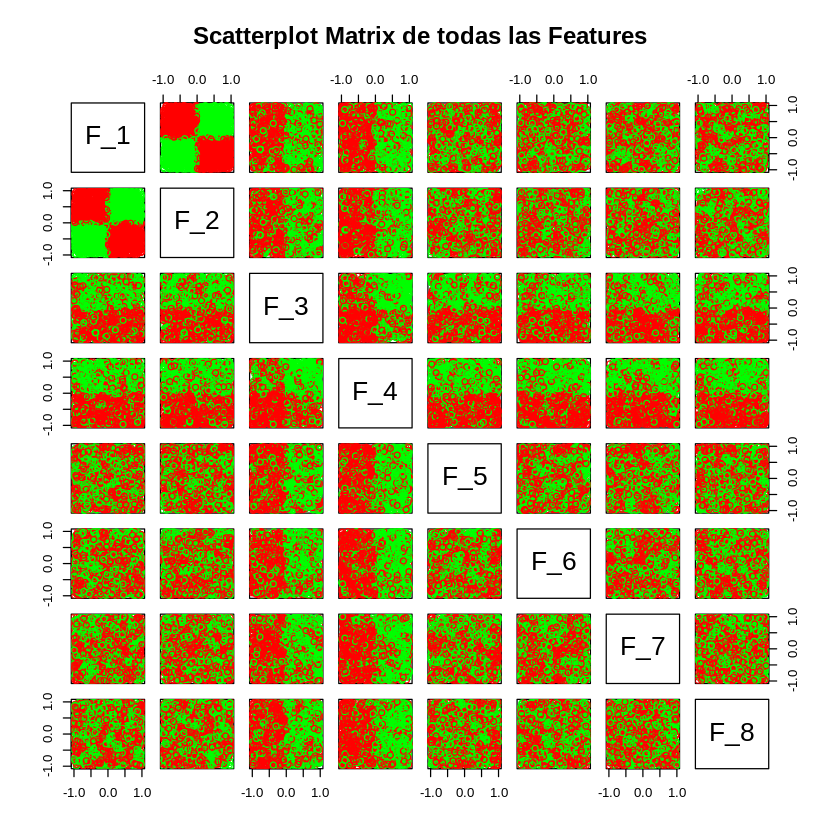

In [ ]:
class_colors <- c("red", "green")
# Creamos un scatterplot matrix con todas las features
pairs(datosBDF[, 1:d], col = class_colors[as.numeric(datosBDF$Class)], pch = 1, main = "Scatterplot Matrix de todas las Features")

Con este gráfico podemos ver claramente como las dos primeras features determinan las clases con un XOR. También se puede ver que la F_3 y F_4 logran separar una gran cantidad de los datos.

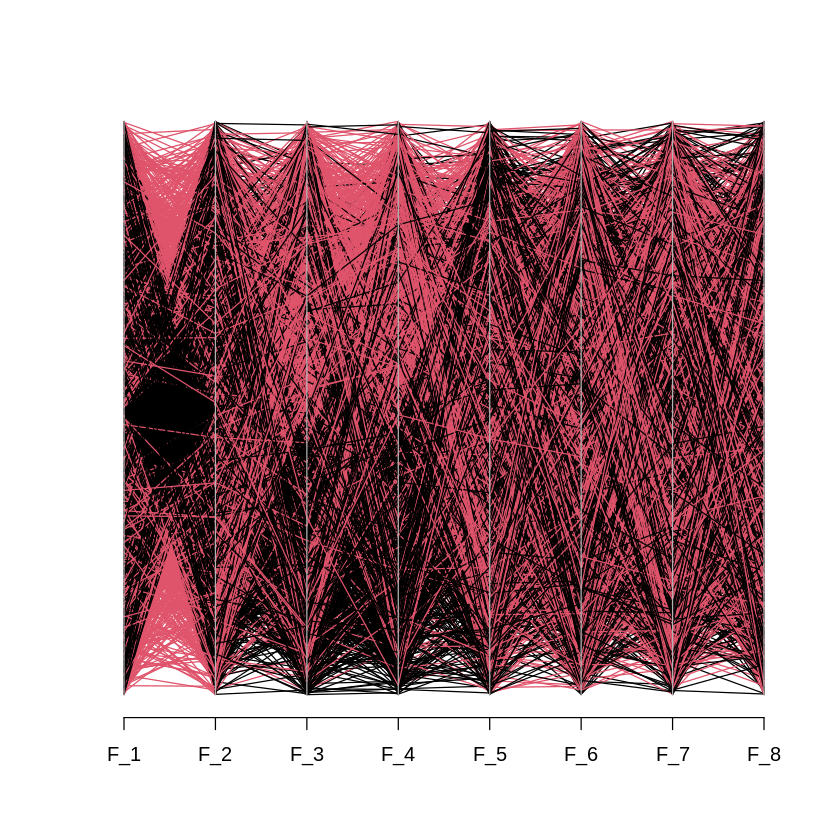

In [ ]:
parcoord(datosBDF[, 1:d],col=datosBDF[, d+1])

En este gráfico se puede apreciar como claramente F_1 y F_2 estan involucradas fuertemente en la decisión de las clases ya que para nada se ven como el ruido aleatorio que se perciben desde la feature 5 a 8.

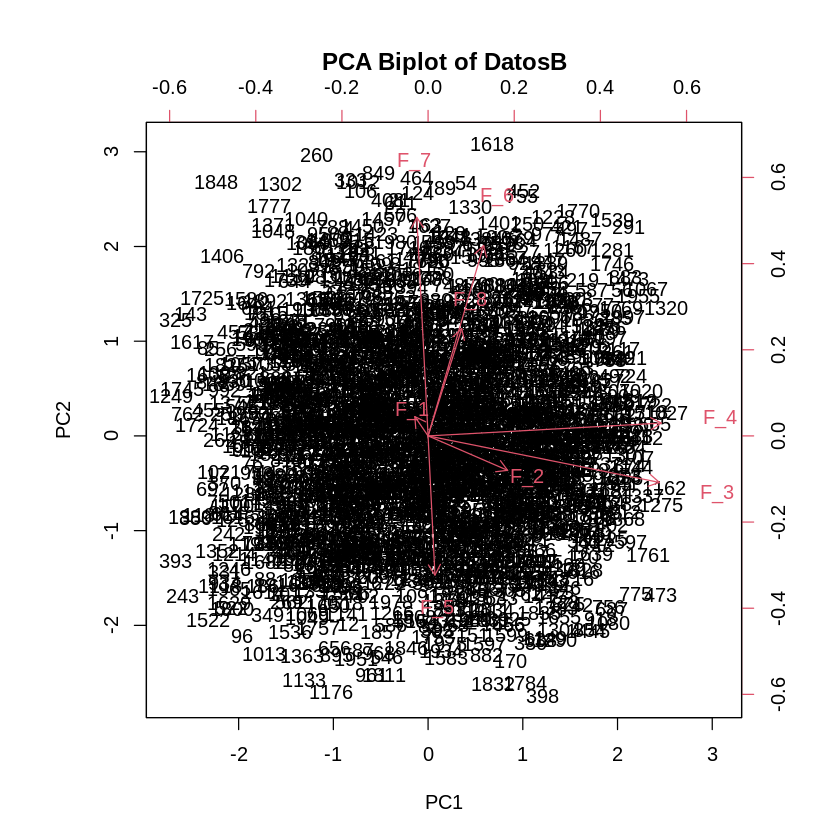

In [ ]:
pca_datosB <- prcomp(datosBDF[, 1:d], center = TRUE, scale. = TRUE)
biplot(pca_datosB, scale = 0,
       main = "PCA Biplot of DatosB")

Nuevamente sucede lo mismo que con el punto anterior con este gráfico, ya que las features siguien siendo generadas por ruído uniforme, por lo que no existe ninguna que realmente pueda separar los datos ni exiten dos features que esten correlacionadas.

### Selección de variables

In [ ]:
cat("\nWrapper Greedy Forward Random Forest")
DB.FORW.rf <- forward.ranking(datosB[,1:d],datosB[,d+1],method="rf.est", verbosity=1)
cat("\n\nWrapper Greedy Forward LDA")
DB.FORW.lda <- forward.ranking(datosB[,1:d],datosB[,d+1],method="lda.est", verbosity=1)
cat("\n\nWrapper Greedy Forward SVM")
DB.FORW.svm <- forward.ranking(datosB[,1:d],datosB[,d+1],method="svm.est", verbosity=1)

cat("\n\n")
cat("\n\nWrapper Greedy Backward Random Forest")
DB.BACK.rf <- backward.ranking(datosB[,1:d],datosB[,d+1],method="rf.est", verbosity=1)
cat("\n\nWrapper Greedy Backward LDA")
DB.BACK.lda <- backward.ranking(datosB[,1:d],datosB[,d+1],method="lda.est", verbosity=1)
cat("\n\nWrapper Greedy Backward SVM")
DB.BACK.svm <- backward.ranking(datosB[,1:d],datosB[,d+1],method="svm.est", verbosity=1)

cat("\n\n")
cat("\nKruskal-Wallis")
DB.KRUS <- kruskal.ranking(datosB[,1:d],datosB[,d+1], verbosity=1)

cat("\n\n")
cat("\nRFE Random Forest")
DB.RFE.rf <- rfe.ranking(datosB[,1:d],datosB[,d+1],method="imp.rf", verbosity=1)
cat("\n\nRFE SVM")
DB.RFE.svm <- rfe.ranking(datosB[,1:d],datosB[,d+1],method="imp.linsvm", verbosity=1)


Wrapper Greedy Forward Random Forest
Final ranking 
Features:  3 4 7 2 1 6 5 8

Wrapper Greedy Forward LDA
Final ranking 
Features:  4 5 6 7 1 3 8 2

Wrapper Greedy Forward SVM
Final ranking 
Features:  4 6 7 3 2 8 1 5



Wrapper Greedy Backward Random Forest
Final ranking 
Features:  2 1 8 6 7 5 3 4

Wrapper Greedy Backward LDA
Final ranking 
Features:  4 7 6 5 1 3 8 2

Wrapper Greedy Backward SVM
Final ranking 
Features:  4 5 3 7 2 1 8 6


Kruskal-Wallis
Final ranking 
Features:  4 3 2 6 8 7 1 5


RFE Random Forest
Final ranking 
Features:  2 1 3 4 7 5 8 6

RFE SVM
Final ranking 
Features:  4 3 8 1 6 5 7 2

### Análsis

Para este problema podemos ver que Kruskal-Wallis no tuvo un desempeño tan bueno como en el anterior, claramente se debe a que como el problema es el XOR para las dos primeras features, tiene problema en encontrar distribuciones mirando de una única variable a la vez.

Wrapper Forward no logró obtener las dos primeras features ya que al agregar de a una nunca pudo determinar que con esas 2 se podia solucionar el problema.

Wrapper Backward con random forest logró determinar que las últimas que debía sacar eran las dos primeras features, eso se debió a que si sacaba alguna el modelo empeoraba mucho. Esto no ocurrio para LDA y SVM, probablemente se deba a la forma en la que funcionan estos clasificadores.

RFE con Random Forest logro determinar las dos variables mas importantes, seguidas de las variables 3 y 4. Esto no ocurrió con SVM, donde no logró determinar las primeras dos pero si la 3 y la 4, probablemente se deba nuevamente al modelo y una dificultad del mismo con el problema del XOR.

# Ejercicio 3

## Función de generación

In [ ]:
# Función para crear la matriz de covarianza
covM <- function(d, C) diag((C * sqrt(d))**2, d)

diagonales <- function(n, d, C) {
  # Clase 0
  c0 <- mvrnorm(n = n / 2, mu = rep(-1, d), Sigma = covM(d, C))
  c0 <- cbind(c0, 0)
  # Clase 1
  c1 <- mvrnorm(n = n / 2, mu = rep(1, d), Sigma = covM(d, C))
  c1 <- cbind(c1, 1)

  flist <- rbind(c0, c1)

  # Crear DataFrame
  df <- as.data.frame(flist)
  colnames(df) <- c(paste0("dim_", 0:(d - 1)), "class")

  df$class <- as.factor(df$class)

  return(df)
}

In [ ]:
crea.ruido.diags<-function(n=100,d=2, min=-1, max=1){
  x<-runif(n*d,min=min,max=max)	#genero los datos
  dim(x)<-c(n,d)
  return(as.data.frame(x))
}

# Decidí que el rango de las variables uniformes sea de -1-(3*sd) a 1+(3*sd)
generateNoisyDiag <- function(d, n, C, nd) {
  datos_relevantes <- diagonales(n, d, C)
  ruido <- crea.ruido.diags(n, nd, -1-(C * sqrt(d)*3), 1+(C * sqrt(d)*3))
  datos <- cbind(cbind(datos_relevantes[,-(d+1)], ruido), as.factor(datos_relevantes[,d+1]))
  return(datos)
}

## Experimento

In [ ]:
d <- 10
n <- 100
C <- 2
nd <- 90
num_reps <- 30
methods <- c("forward_RF", "forward_SVM", "backward_RF", "backward_SVM", "kruskal_wallis", "RFE_RF", "RFE_SVM")

La siguiente celda tardaba tanto en correr que colab me sacaba, por lo que la corrí en mi computadora y guarde el objeto con los aciertos. Un detalle importante es que tardo aproximadamente 3 horas (en colab tomaba mas de 7 si no me sacaba antes).

In [ ]:
resultados_aciertos <- matrix(0, nrow = num_reps, ncol = length(methods))
colnames(resultados_aciertos) <- methods
verbosity = 1
start_time <- Sys.time()

for (rep in 1:num_reps) {
  datos <- generateNoisyDiag(d, n, C, nd)

  # Aplicar cada método
  for (metodo in methods) {
    if (verbosity > 0) {
      elapsed_time <- as.numeric(Sys.time() - start_time, units = "secs")
      cat("Rep", rep, "- method", metodo, "- tiempo", elapsed_time, "segundos \n")
      flush.console()
    }
    ranking <- switch(metodo,
                      "forward_RF" = {
                        # Código para el método forward usando Random Forest
                        forward.ranking(datos[, 1:(d + nd)], datos[,d+nd+1], method = "rf.est",tot.trees=100,equalize.classes=F)
                      },
                      "forward_SVM" = {
                        # Código para el método forward usando SVM
                        forward.ranking(datos[, 1:(d + nd)], datos[,d+nd+1], method = "svm.est")
                      },
                      "backward_RF" = {
                        # Código para el método backward usando Random Forest
                        backward.ranking(datos[, 1:(d + nd)], datos[,d+nd+1], method = "rf.est",tot.trees=100,equalize.classes=F)
                      },
                      "backward_SVM" = {
                        # Código para el método backward usando SVM
                        backward.ranking(datos[, 1:(d + nd)], datos[,d+nd+1], method = "svm.est")
                      },
                      "kruskal_wallis" = {
                        # Código para el método Kruskal-Wallis
                        kruskal.ranking(datos[, 1:(d + nd)], datos[,d+nd+1])
                      },
                      "RFE_RF" = {
                        # Código para RFE usando Random Forest
                        rfe.ranking(datos[, 1:(d + nd)], datos[,d+nd+1], method = "imp.rf",tot.trees=100,equalize.classes=F)
                      },
                      "RFE_SVM" = {
                        # Código para RFE usando SVM
                        rfe.ranking(datos[, 1:(d + nd)], datos[,d+nd+1], method = "imp.linsvm")
                      },
                      stop("Método no válido")
    )

    # Calcular el número de aciertos (cuántas de las 10 relevantes están en los primeros 10 lugares)
    aciertos <- sum(ranking[1:10] <= d)
    resultados_aciertos[rep, metodo] <- aciertos
  }
}

if (verbosity > 0) {
  elapsed_time <- as.numeric(Sys.time() - start_time, units = "secs")
  cat("Termino en", elapsed_time, "segundos \n")
  flush.console()
}

## Resultados

Cargué el archivo con el objeto de R para hacer el analisis

In [ ]:
# Load the .RData file
load("resultados_aciertos.RData")
resultados_aciertos

forward_RF forward_SVM backward_RF backward_SVM kruskal_wallis RFE_RF
 [1,] 1          0           2           2            2              3     
 [2,] 3          3           1           3            4              5     
 [3,] 3          3           1           2            4              3     
 [4,] 3          0           1           1            5              2     
 [5,] 2          3           1           3            5              5     
 [6,] 0          1           1           1            1              1     
 [7,] 1          1           0           0            2              2     
 [8,] 0          2           0           3            1              1     
 [9,] 2          2           2           3            4              2     
[10,] 2          3           3           3            4              4     
[11,] 2          0           0           2            2              3     
[12,] 1          2           4           2            6              3     
[13,] 2          1           4           2            4              3     
[14,] 0          3           3           4            4              4     
[15,] 1          2           2           2            3              3     
[16,] 2          2           0           2            4              5     
[17,] 3          1           1           2            5              4     
[18,] 1          1           1           2            2              1     
[19,] 0          1           1           1            2              2     
[20,] 2          2           3           2            5              5     
[21,] 2          3           1           3            4              4     
[22,] 4          2           1           0            4              3     
[23,] 2          2           2           3            6              4     
[24,] 3          1           1           2            3              1     
[25,] 1          2           1           2            5              2     
[26,] 3          3           3           3            5              5     
[27,] 0          3           0           2            3              2     
[28,] 2          3           2           3            5              3     
[29,] 5          2           0           1            1              2     
[30,] 1          3           2           3            5              3     
      RFE_SVM
 [1,] 0      
 [2,] 3      
 [3,] 3      
 [4,] 4      
 [5,] 2      
 [6,] 2      
 [7,] 1      
 [8,] 3      
 [9,] 3      
[10,] 3      
[11,] 3      
[12,] 3      
[13,] 3      
[14,] 4      
[15,] 2      
[16,] 4      
[17,] 2      
[18,] 2      
[19,] 2      
[20,] 2      
[21,] 4      
[22,] 2      
[23,] 5      
[24,] 2      
[25,] 3      
[26,] 4      
[27,] 4      
[28,] 3      
[29,] 0      
[30,] 3

In [ ]:
# Calcular el porcentaje de aciertos por cada método
porcentajes_aciertos <- colMeans(resultados_aciertos) / 10 * 100

# Mostrar los resultados
for (metodo in methods) {
  cat(sprintf("Método: %s - Porcentaje de aciertos: %.2f%%\n", metodo, porcentajes_aciertos[metodo]))
}

Método: forward_RF - Porcentaje de aciertos: 18.00%
Método: forward_SVM - Porcentaje de aciertos: 19.00%
Método: backward_RF - Porcentaje de aciertos: 14.67%
Método: backward_SVM - Porcentaje de aciertos: 21.33%
Método: kruskal_wallis - Porcentaje de aciertos: 36.67%
Método: RFE_RF - Porcentaje de aciertos: 30.00%
Método: RFE_SVM - Porcentaje de aciertos: 27.00%


## Análisis
Sorprendentemente el mejor resultado en promedio fue obtenido por el test no paramétrico, yo esperaba que fuera el RFE con SVM debido al tipo de problema, ya que diagonales me parece que es un problema donde los árboles tendian a fallar más y la ganancia de informacion no era una medida razonable como para que Kruskal-Wallis tuviera un mejor desempeño.

Wrapper Backward Random forest obtuvo el peor resultado, probablemente por el tipo de clasificador, ya que este mismo método de selección pero con SVM obtuvo mejores resultado que el método Wrapper forward.

Los métodos con RFE tuvieron un mejor desempeño que los wrappers, como era esperable.

Una cosa a destacar es que ambos metodos Wrapper fueron mucho mas lentos que el test no paramétrico o RFE, esto sumado a que los resultados fueron mejores con estos últimos, no veo razón alguna para utilizar métodos Wrapper por sobre los demás.


# Ejercicio 4

En este ejercicio decidí utilizar un conjunto de datos para la prediccion de enfermedades renales crónicas encontrado en la siguiente página web https://www.kaggle.com/datasets/abhia1999/chronic-kidney-disease.

Las variables medidas son las siguientes:


1.   Presión Sanguinea (Bp)
2.   Densidad de la orina (Sg)
3.   Albumina (Al)
4.   Glucosa (Su)
5.   Presencia de Globulos rojos (Rbc)
6.   Urea en sangre (Bu)
7.   Creatinina Sérica (Sc)
8.   Sodio (Sod)
9.   Potasio (Pot)
10.  Hemoglobina (Hemo)
11. Recuento de glóbulos blancos (Wbcc)
12. Recuento de glóbulos rojos (Rbcc)
13. Hipertensión (Htn)
14. Clase (Class)



In [ ]:
ckd.dataset <- read.csv("ckd_dataset.csv")
ncol <- ncol(ckd.dataset)
ckd.data = ckd.dataset[, -ncol]
ckd.class = ckd.dataset[, ncol]

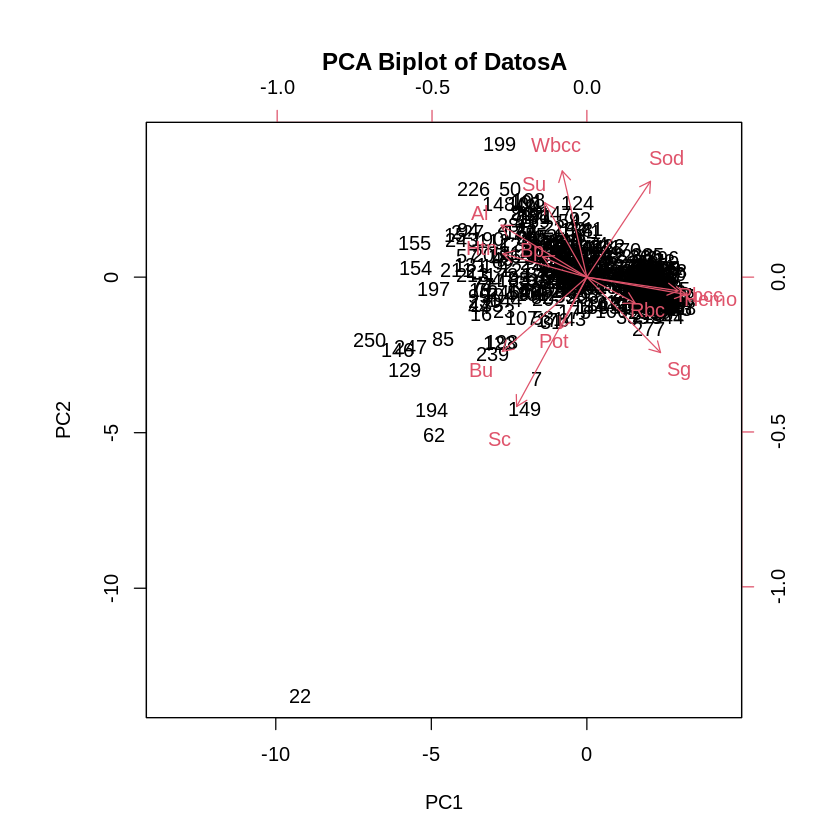

In [ ]:
pca <- prcomp(ckd.data, center = TRUE, scale. = TRUE)
biplot(pca, scale = 0,
       main = "PCA Biplot of DatosA")

Claramente el sample 22 es un outlier y como no conozco un experto para consultar decidí sacarlo del conjunto de datos.

In [ ]:
ckd.data = ckd.dataset[-22, -ncol]
ckd.class = ckd.dataset[-22, ncol]

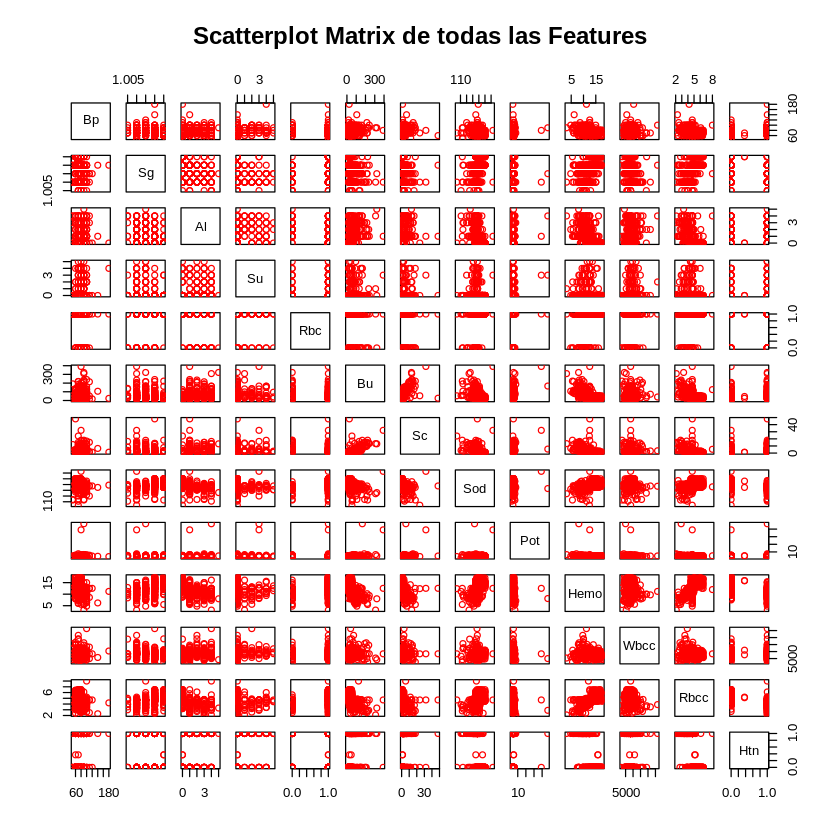

In [ ]:
class_colors <- c("red", "green")
# Creamos un scatterplot matrix con todas las features
pairs(ckd.data, col = class_colors[as.numeric(ckd.class)], pch = 1, main = "Scatterplot Matrix de todas las Features")

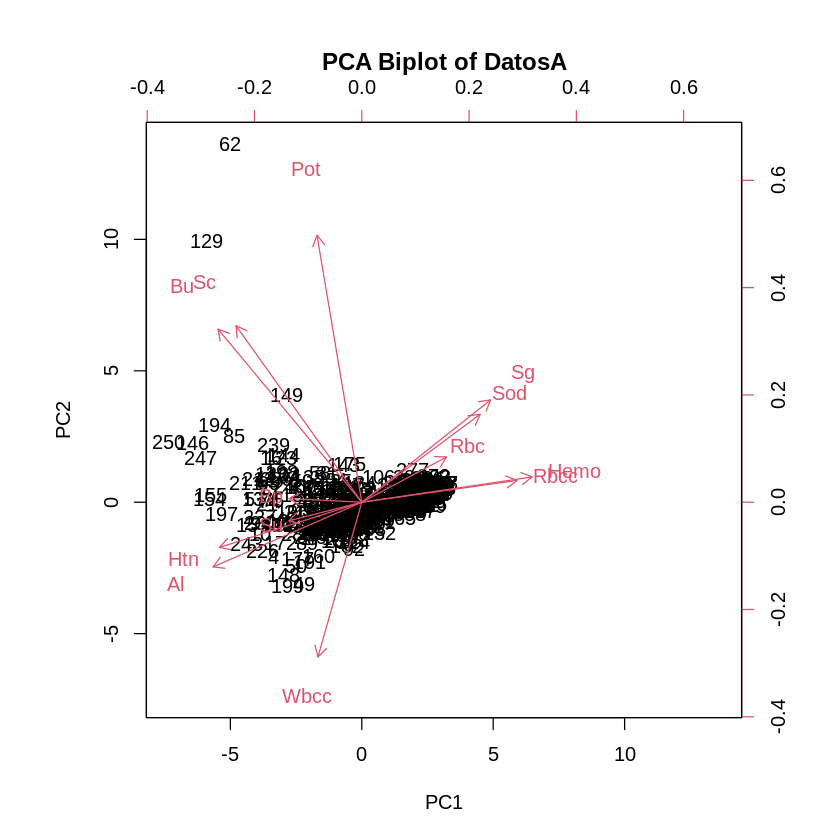

In [ ]:
pca <- prcomp(ckd.data, center = TRUE, scale. = TRUE)
biplot(pca, scale = 0,
       main = "PCA Biplot of DatosA")

Se pueden apreciar muchas agrupaciones interesantes entre las variables, podemos encontrar los siguientes conjuntos:


*   Hemo y Rbcc: Hemoglobina y recuento de globulos rojos, lo cual tiene sentido ya que la hemoglobina es una proteina que se encuentra dentro de los globulos
*   Sg y Sod: Densidad de la orina y sodio, al investigar un poco encontre que la densidad de la orina aumenta cuando se tiene un alto nivel de sodio en sangre.
*   Bu y Sc: Urea en sangre y creatinina sérica, ambas mediciones corresponden a desechos del cuerpo los cuales en el caso de una falla renal van a estar por encima de lo normal.
*   Htn y Al: Hipertensión y Albúmina, entre estas no pude encontrar una correlación

Parecería que el potasio afecta en gran medida a la proyección de PC2, pero analizando los samples, parecería que esto se debe principalmente por un par de puntos que podrían ser considerados outliers. Decidí no eliminarlos ya que si miramos el biplot original estos no estaban tan alejados cuando teniamos el sample 22.

En la proyección PC1 parecería que predomina el conjunto de Hemoglobina+Globulos Rojos.





In [ ]:
cat("\nWrapper Greedy Forward Random Forest")
DA.FORW.rf <- forward.ranking(ckd.data,as.factor(ckd.class),method="rf.est", verbosity=1)
cat("\n\nWrapper Greedy Forward LDA")
DA.FORW.lda <- forward.ranking(ckd.data,as.factor(ckd.class),method="lda.est", verbosity=1)
cat("\n\nWrapper Greedy Forward SVM")
DA.FORW.svm <- forward.ranking(ckd.data,as.factor(ckd.class),method="svm.est", verbosity=1)

cat("\n\n")
cat("\n\nWrapper Greedy Backward Random Forest")
DA.BACK.rf <- backward.ranking(ckd.data,as.factor(ckd.class),method="rf.est", verbosity=1)
cat("\n\nWrapper Greedy Backward LDA")
DA.BACK.lda <- backward.ranking(ckd.data,as.factor(ckd.class),method="lda.est", verbosity=1)
cat("\n\nWrapper Greedy Backward SVM")
DA.BACK.svm <- backward.ranking(ckd.data,as.factor(ckd.class),method="svm.est", verbosity=1)

cat("\n\n")
cat("\nKruskal-Wallis")
DA.KRUS <- kruskal.ranking(ckd.data,as.factor(ckd.class), verbosity=1)

cat("\n\n")
cat("\nRFE Random Forest")
DA.RFE.rf <- rfe.ranking(ckd.data,as.factor(ckd.class),method="imp.rf", verbosity=1)
cat("\n\nRFE SVM")
DA.RFE.svm <- rfe.ranking(ckd.data,as.factor(ckd.class),method="imp.linsvm", verbosity=1)


Wrapper Greedy Forward Random Forest
Final ranking 
Features:  10 2 7 3 12 9 13 8 11 1 4 6 5

Wrapper Greedy Forward LDA
Final ranking 
Features:  10 2 3 4 5 9 8 7 11 6 12 1 13

Wrapper Greedy Forward SVM
Final ranking 
Features:  10 3 4 2 13 7 1 11 5 9 12 8 6



Wrapper Greedy Backward Random Forest
Final ranking 
Features:  10 2 7 3 13 5 11 9 8 4 6 1 12

Wrapper Greedy Backward LDA
Final ranking 
Features:  10 2 3 11 12 8 6 7 5 4 9 1 13

Wrapper Greedy Backward SVM
Final ranking 
Features:  10 13 2 4 5 11 7 9 3 6 12 8 1


Kruskal-Wallis
Final ranking 
Features:  10 3 7 2 12 13 8 6 4 5 1 11 9


RFE Random Forest
Final ranking 
Features:  2 10 3 13 7 12 8 4 1 6 5 11 9

RFE SVM
Final ranking 
Features:  7 10 3 2 4 12 5 11 1 6 9 8 13

## Análisis
Todos los métodos menos RFE determinaron que la Hemoglobina es la variable mas importante, RFE para ambos modelos determinó que era la segunda variable mas importante. Esto se debe a que las personas con enfermedades renales crónicas suelen tener anemia provocada por la enfermedad, caracterizada por la reducción de la hemoglobina.

Otras variables que aparecieron en varios métodos como principales fueron Densidad de la orina, creatinina sérica y albúmina. Sorprendentemente todas estas variables estan en algunos de los grupos mencionados mas arriba por lo que claramente son estos 4 grupos los que probablemente determinen si una persona tiene una enfermedad renal crónica o no. En particular, la densidad de la orina disminuye cuando se tiene falla renal, lo mismo ocurre con la albúmina y la creatinina sérica aumenta.

Podemos ver que estas variables o alguna que sea correlativa fueron elegida entre las 5 mas importantes de casi todos los métodos.